In [3]:
!pip install pmdarima

import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


<ipython-input-3-186494d5f94d>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
plt.rcParams['figure.figsize'] = (20,15)

In [9]:
!pip install yfinance

import yfinance as yf

ticker = "AAPL"
start = "2015-01-01"

df = yf.download(ticker, start=start)


[*********************100%%**********************]  1 of 1 completed


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2243 entries, 2015-01-02 to 2023-11-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2243 non-null   float64
 1   High       2243 non-null   float64
 2   Low        2243 non-null   float64
 3   Close      2243 non-null   float64
 4   Adj Close  2243 non-null   float64
 5   Volume     2243 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 122.7 KB


Next, we restrict ourself to the 'Close' column.

In [11]:
df = df['Close']
df

Date
2015-01-02     27.332500
2015-01-05     26.562500
2015-01-06     26.565001
2015-01-07     26.937500
2015-01-08     27.972500
                 ...    
2023-11-22    191.309998
2023-11-24    189.970001
2023-11-27    189.789993
2023-11-28    190.399994
2023-11-29    189.369995
Name: Close, Length: 2243, dtype: float64

<Axes: xlabel='Date'>

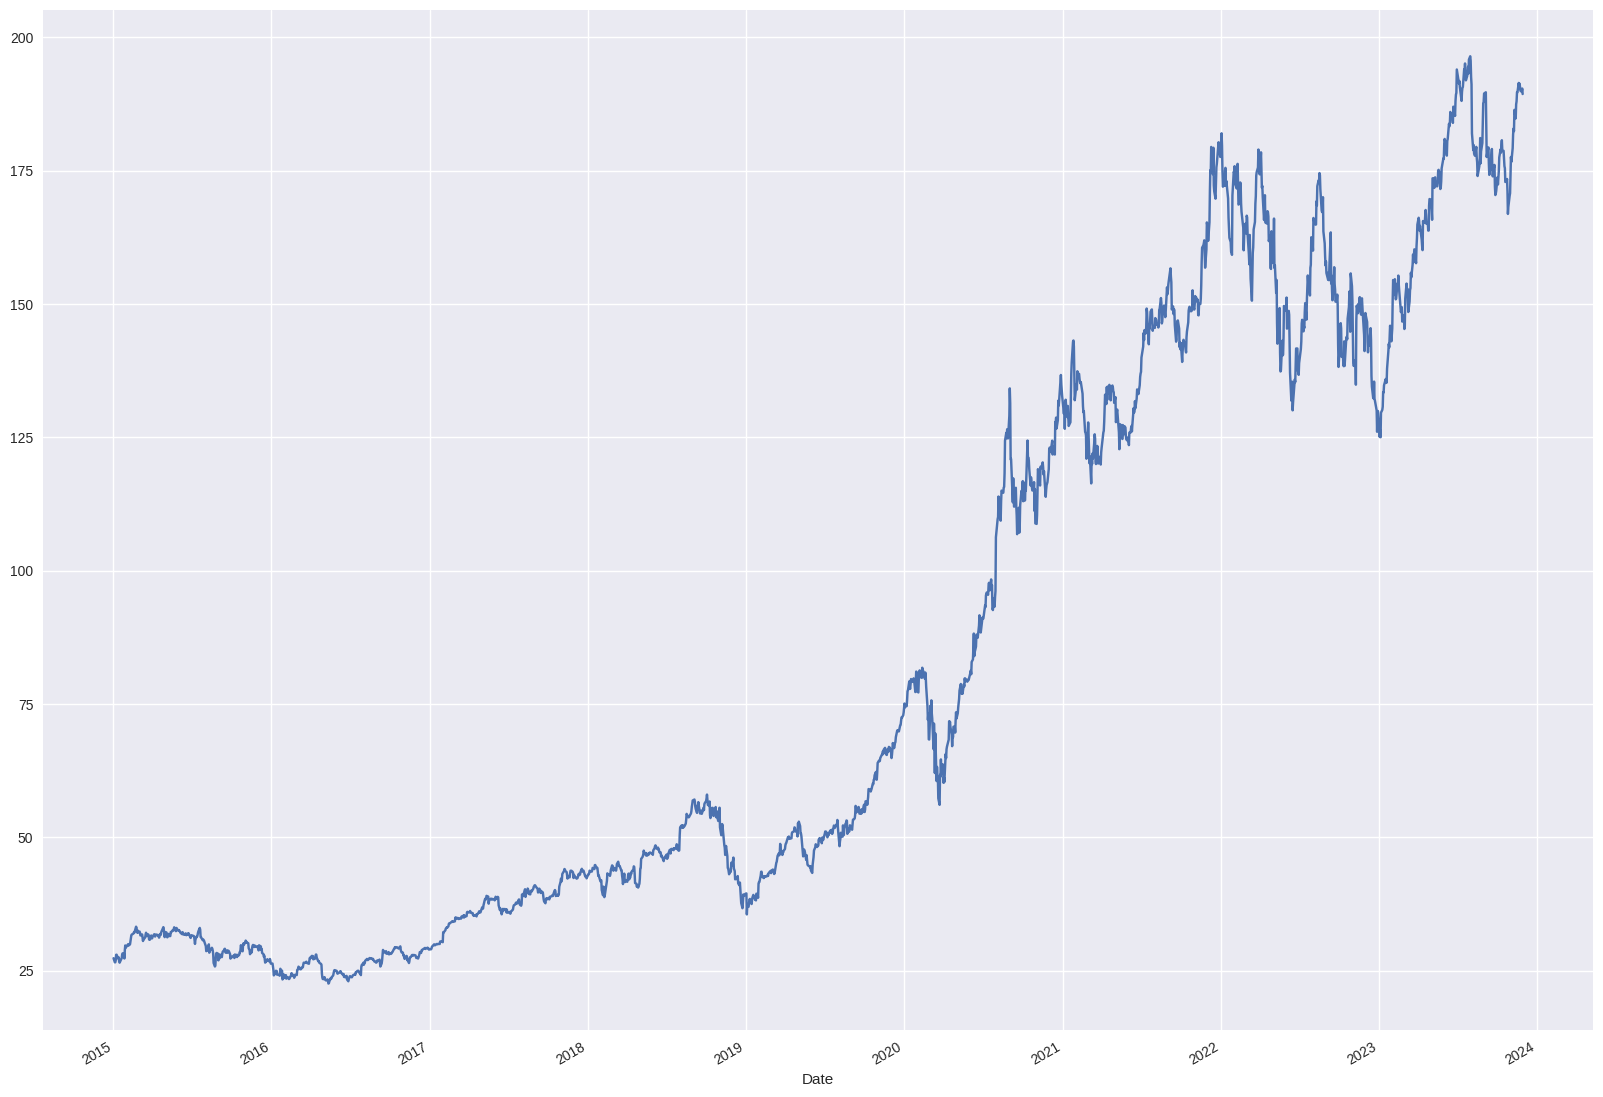

In [12]:
df.plot()

In [13]:
result = adfuller(df)
print(f'Test Statistics : {result[0]} \np-value : {result[1]}')

Test Statistics : 0.17145434906951018 
p-value : 0.9706143342261153


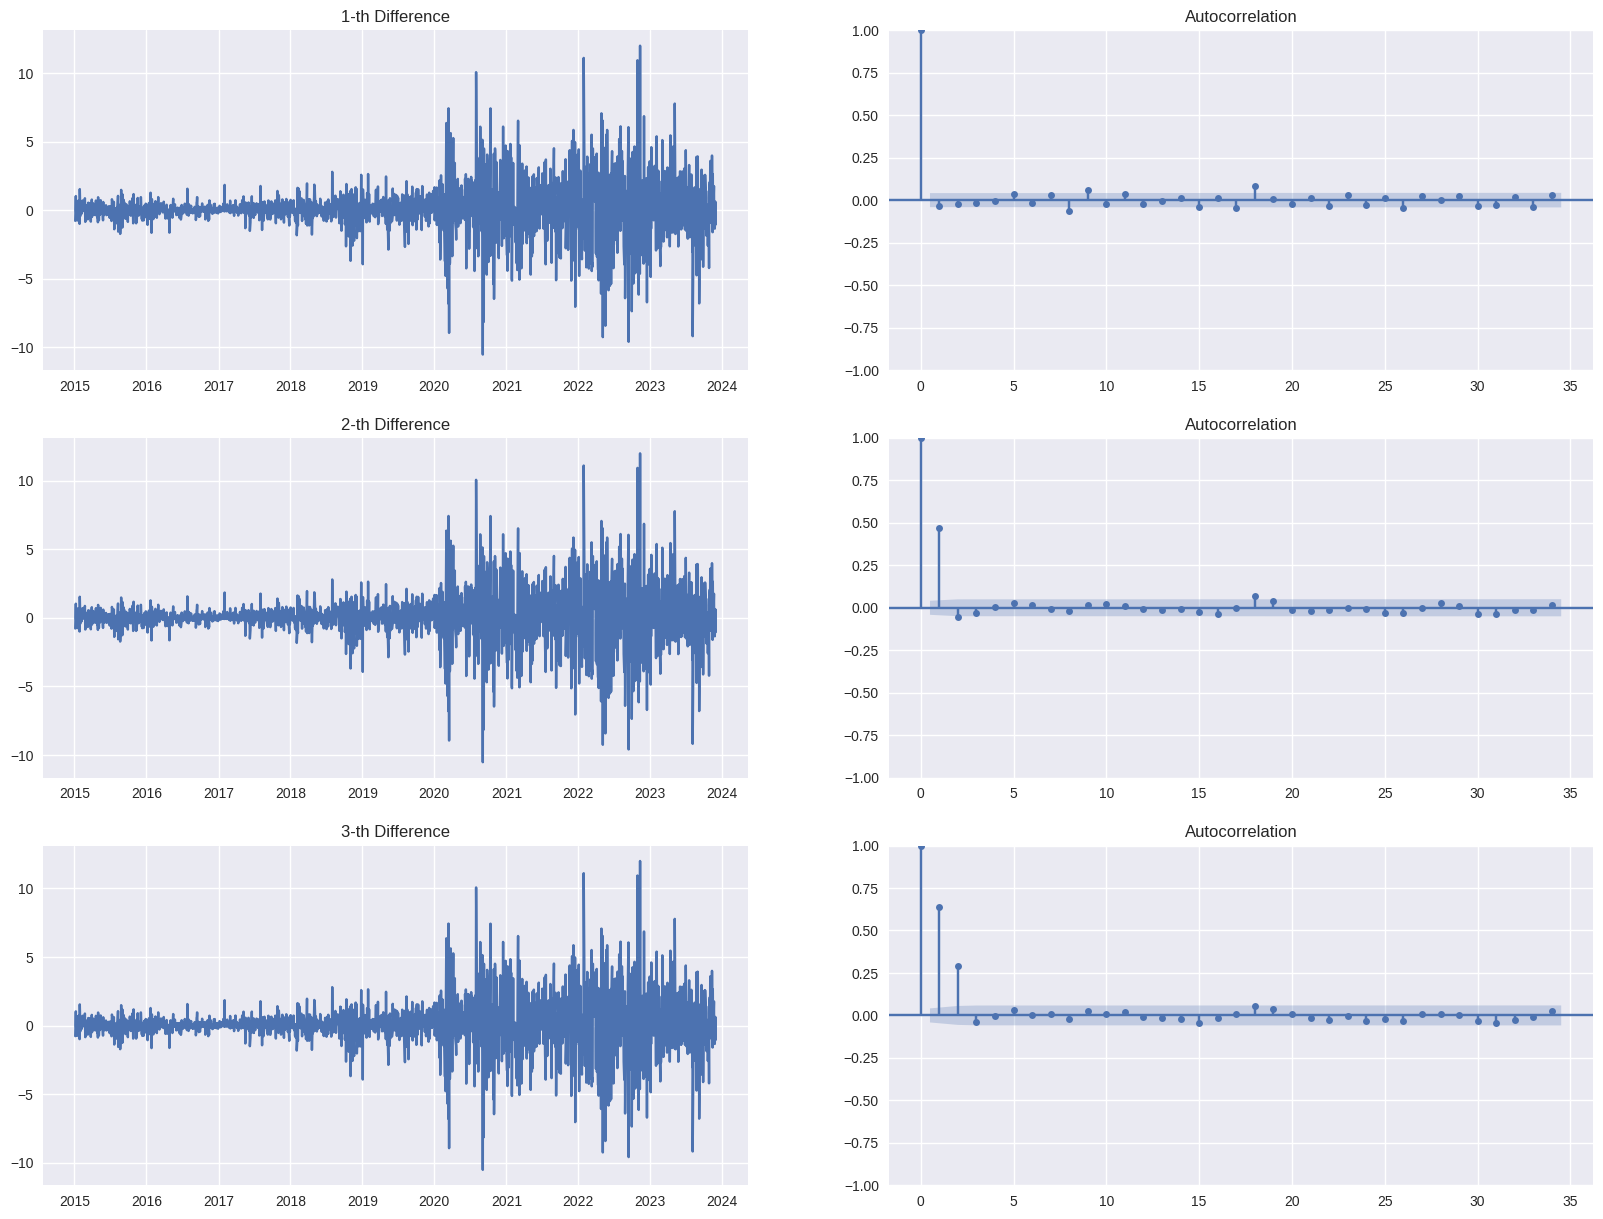

In [14]:
fig, ax = plt.subplots(3,2)
for i in range(3):
    ax[i,0].plot(df.diff())
    ax[i,0].set_title(f'{i+1}-th Difference')
    plot_acf(df.diff(periods=i+1).dropna(), ax=ax[i,1])

So d = 1 seem to be the right choice. Let us check p-values to check if d = 1 is a right choice. Also, it is clear that q = 1.

In [15]:
for i in range(3):
    result = adfuller(df.diff(i+1).dropna())
    print(f'\nFor {i+1}-th diffrence we have the following \nTest Statistics : {result[0]} \np-value : {result[1]}')


For 1-th diffrence we have the following 
Test Statistics : -10.879572924770697 
p-value : 1.3051775719199576e-19

For 2-th diffrence we have the following 
Test Statistics : -8.821243169077814 
p-value : 1.8747739542572e-14

For 3-th diffrence we have the following 
Test Statistics : -9.064705498590806 
p-value : 4.4650268843625685e-15


Hence, we take d = 1. Next, we find p.

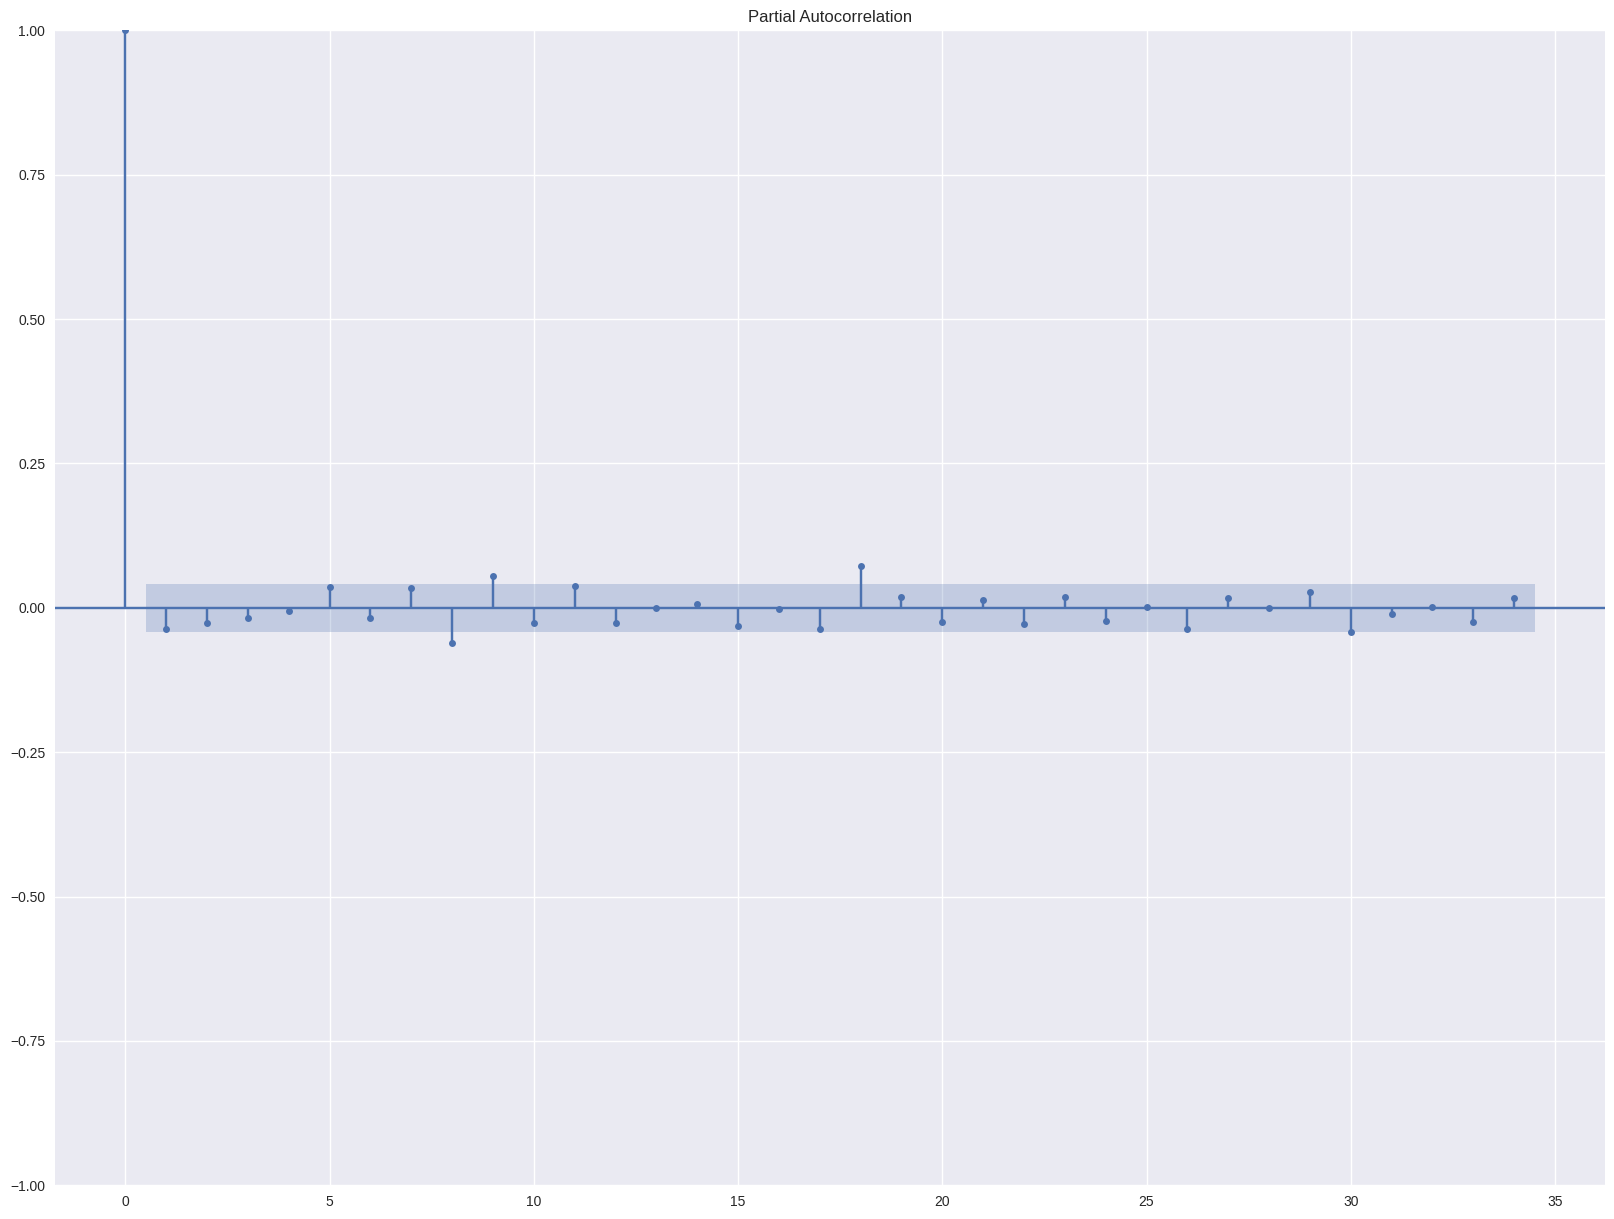

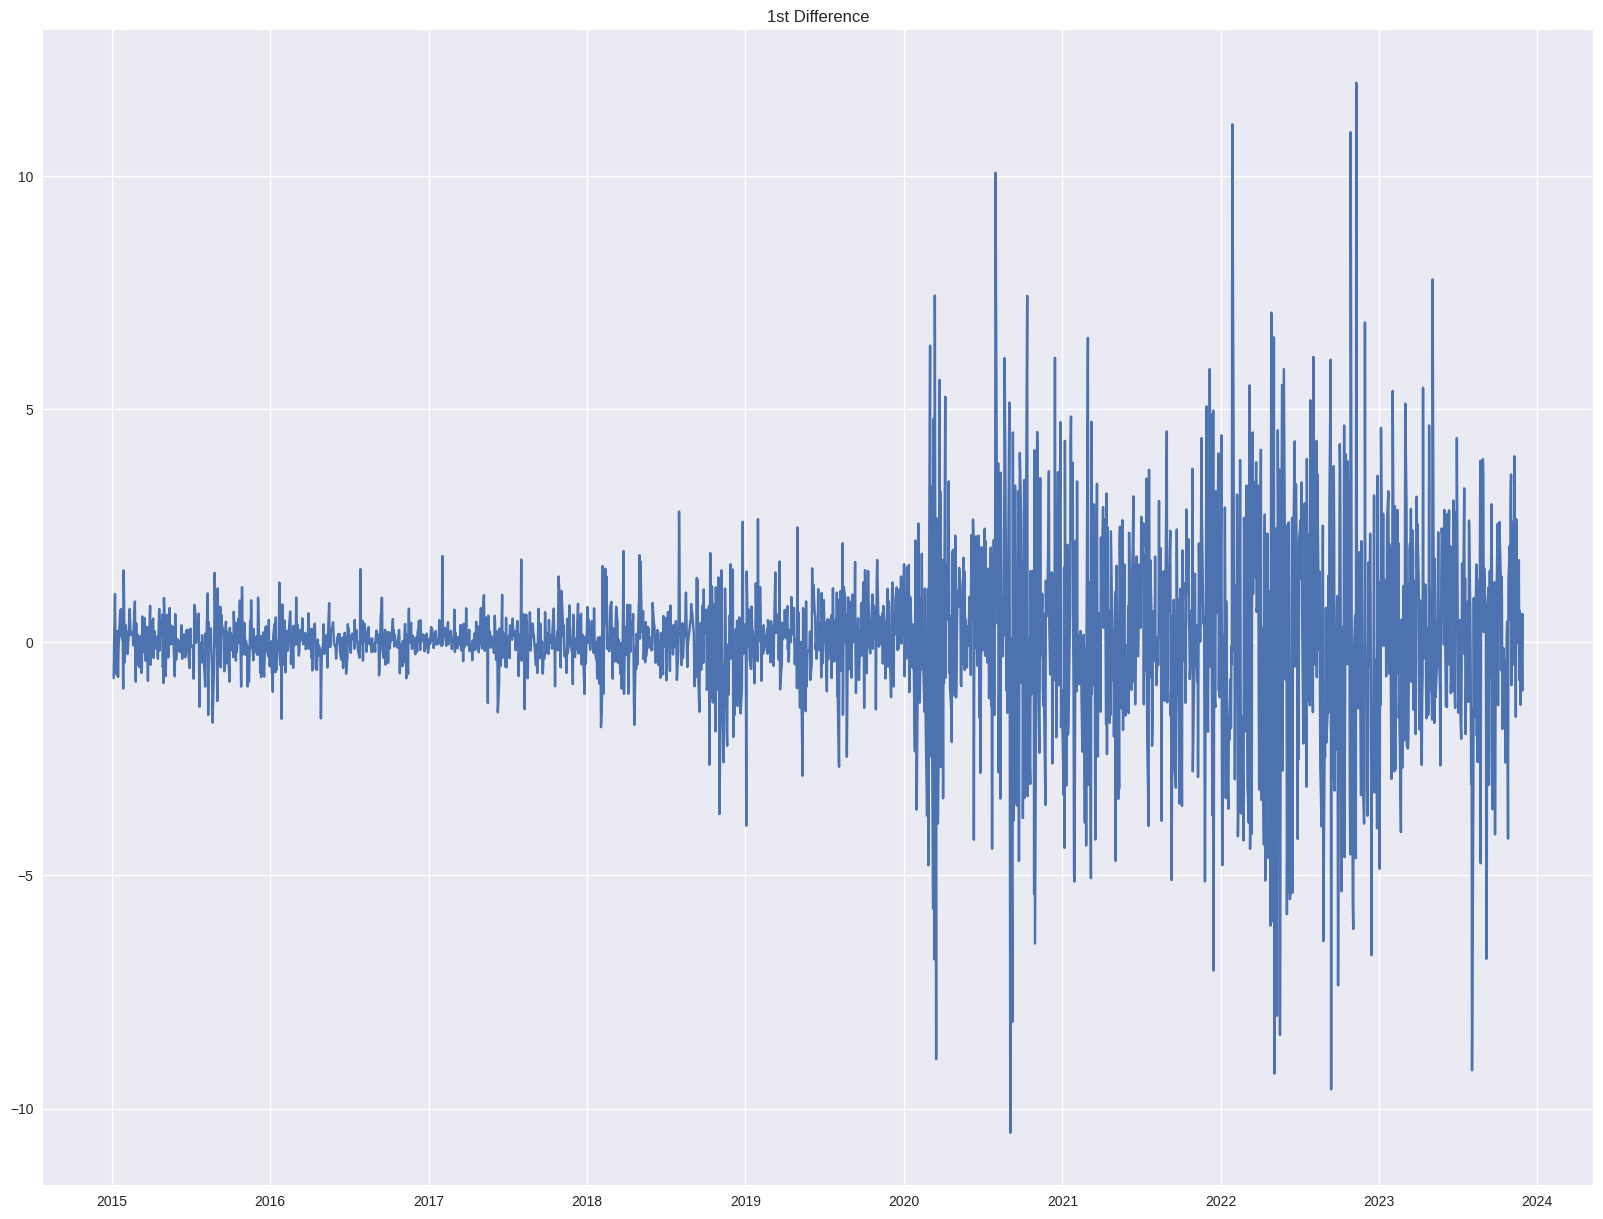

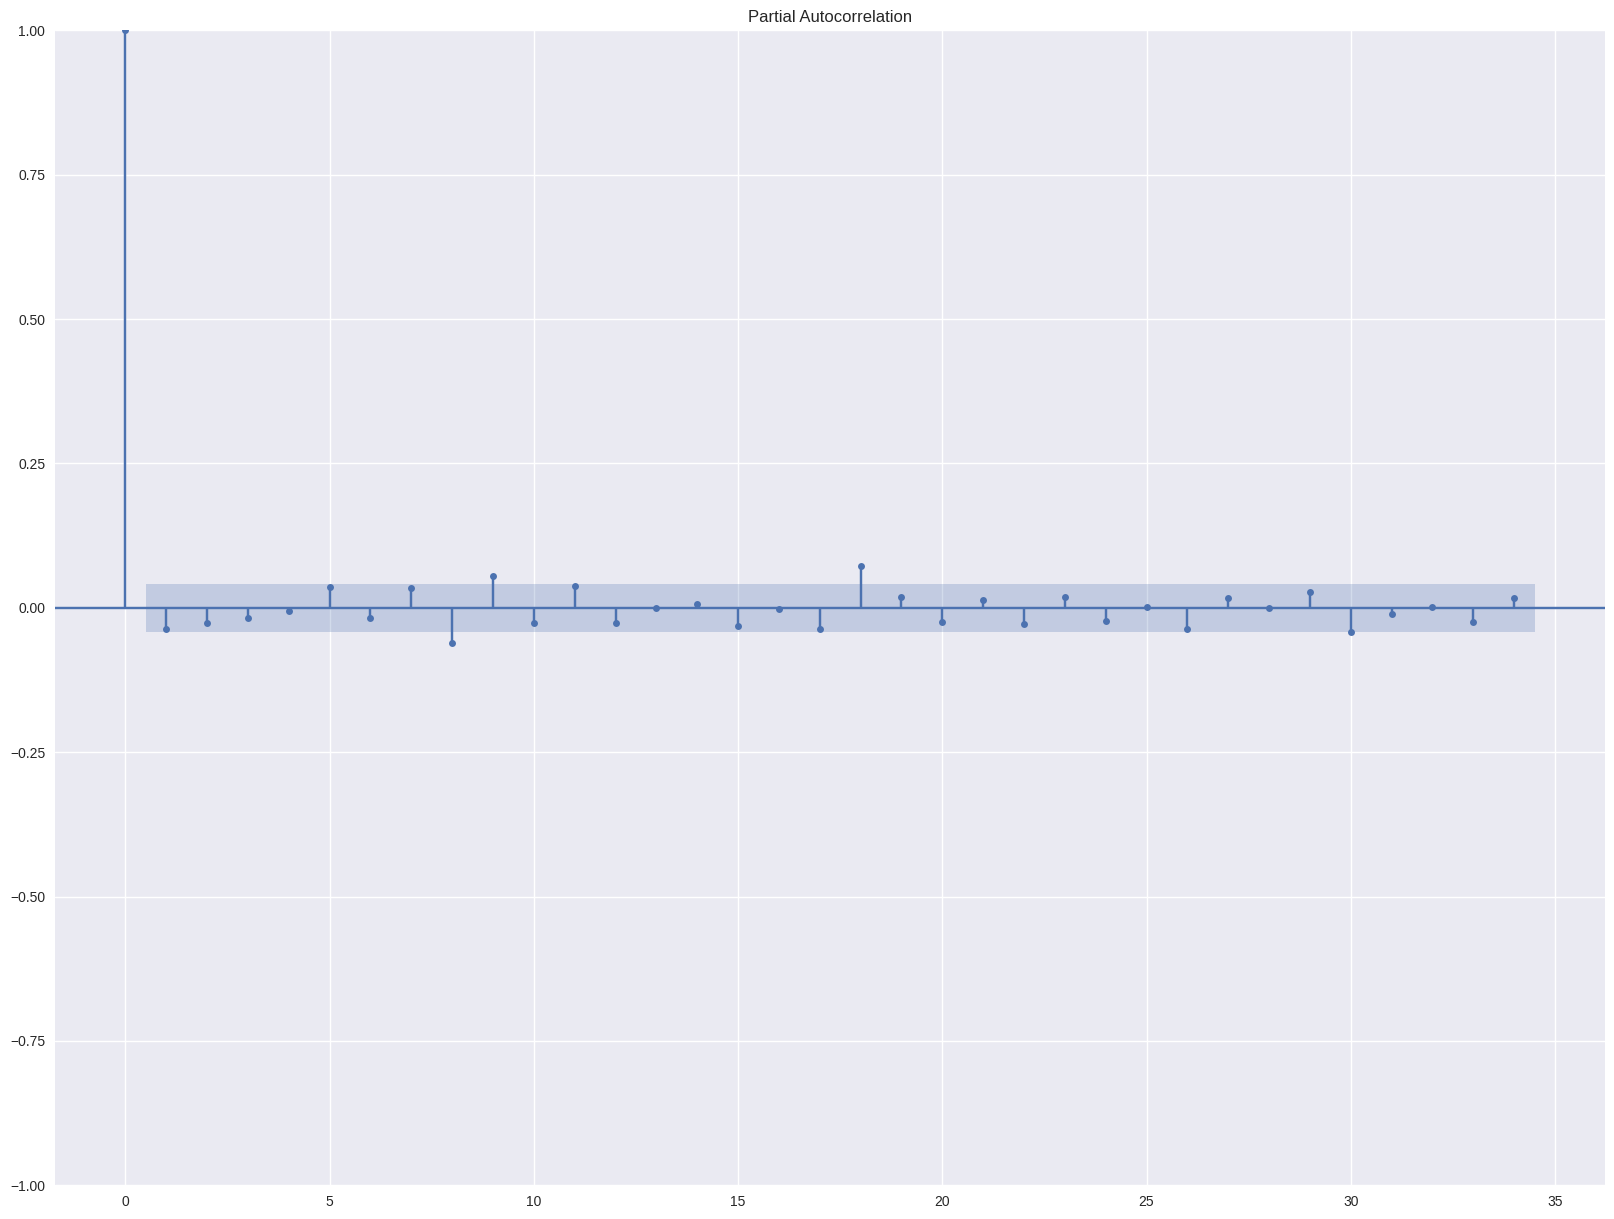

In [16]:
plt.plot(df.diff())
plt.title(f'1st Difference')
plot_pacf(df.diff().dropna())

So p = 1 seem to be right.

In [17]:
model = ARIMA(df, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2243
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4529.348
Date:                Wed, 29 Nov 2023   AIC                           9064.697
Time:                        23:31:28   BIC                           9081.842
Sample:                             0   HQIC                          9070.956
                               - 2243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4215      0.251      1.676      0.094      -0.071       0.914
ma.L1         -0.4598      0.248     -1.855      0.064      -0.946       0.026
sigma2         3.3287      0.050     66.703      0.0

<Axes: ylabel='Density'>

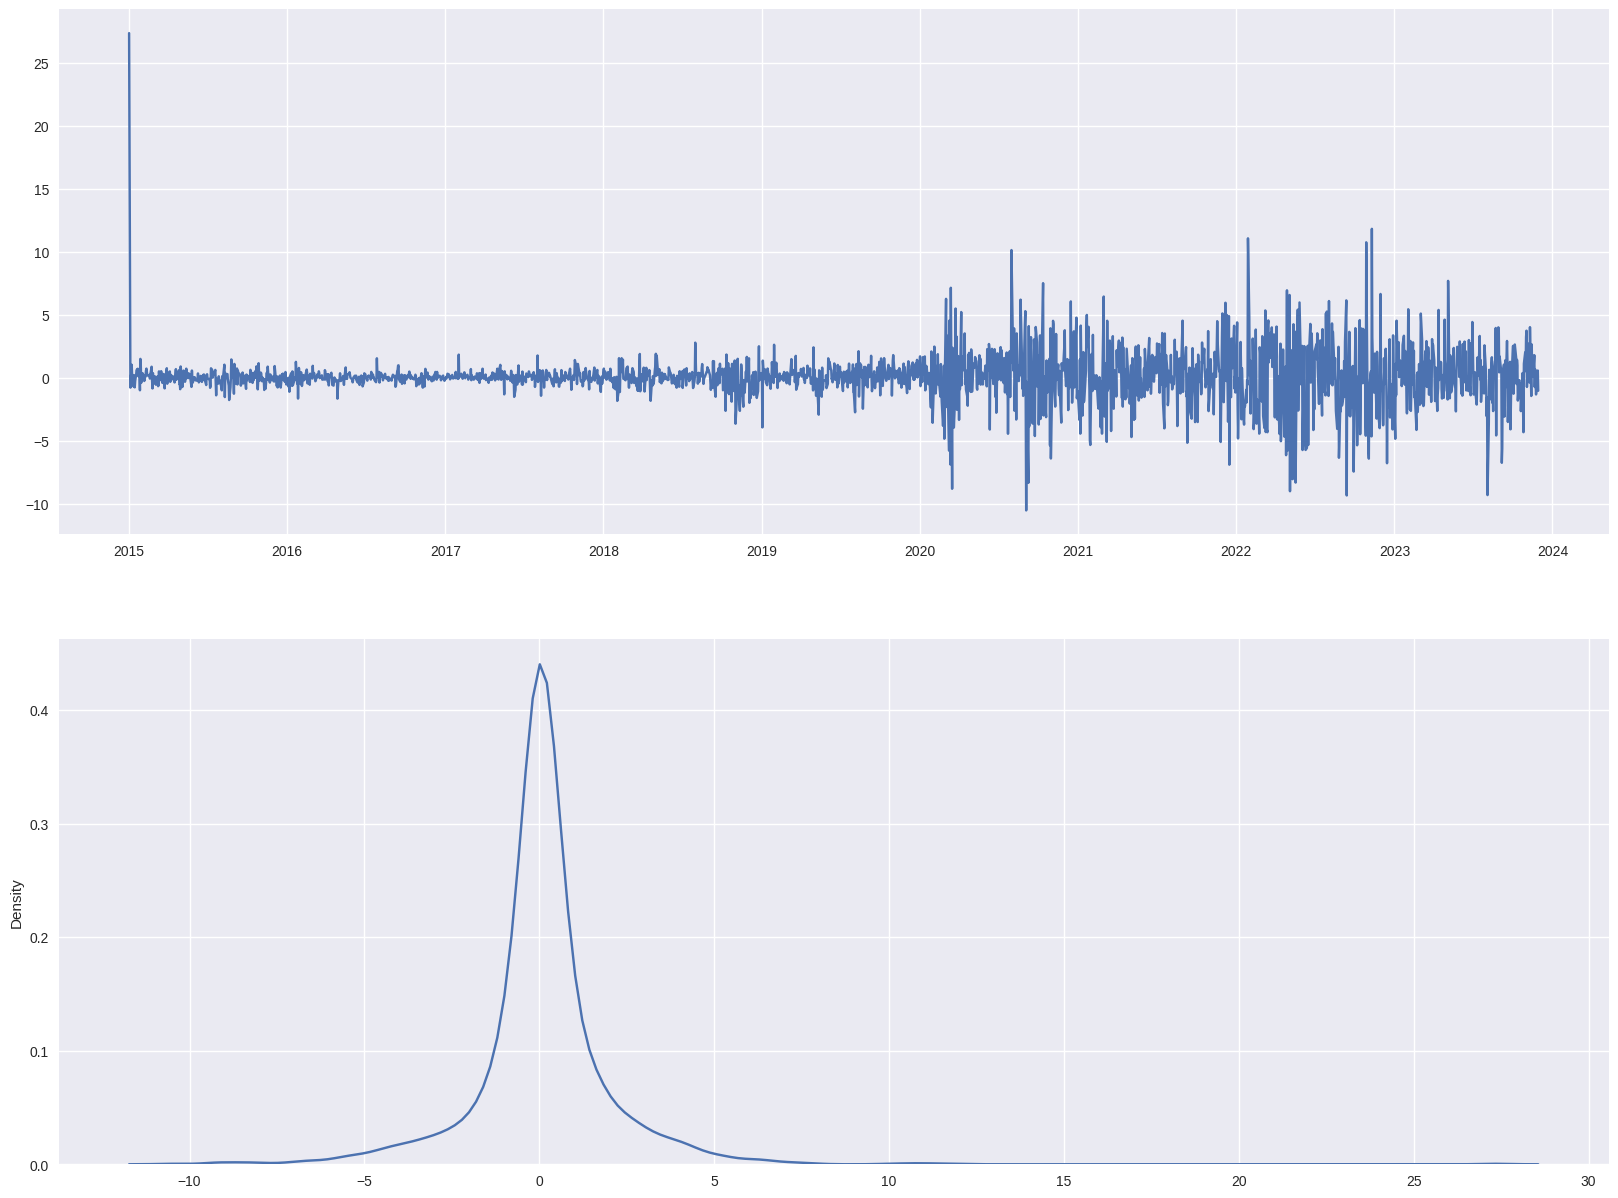

In [18]:
plt.subplot(211)
plt.plot(model_fit.resid)
plt.subplot(212)
sns.kdeplot(model_fit.resid)

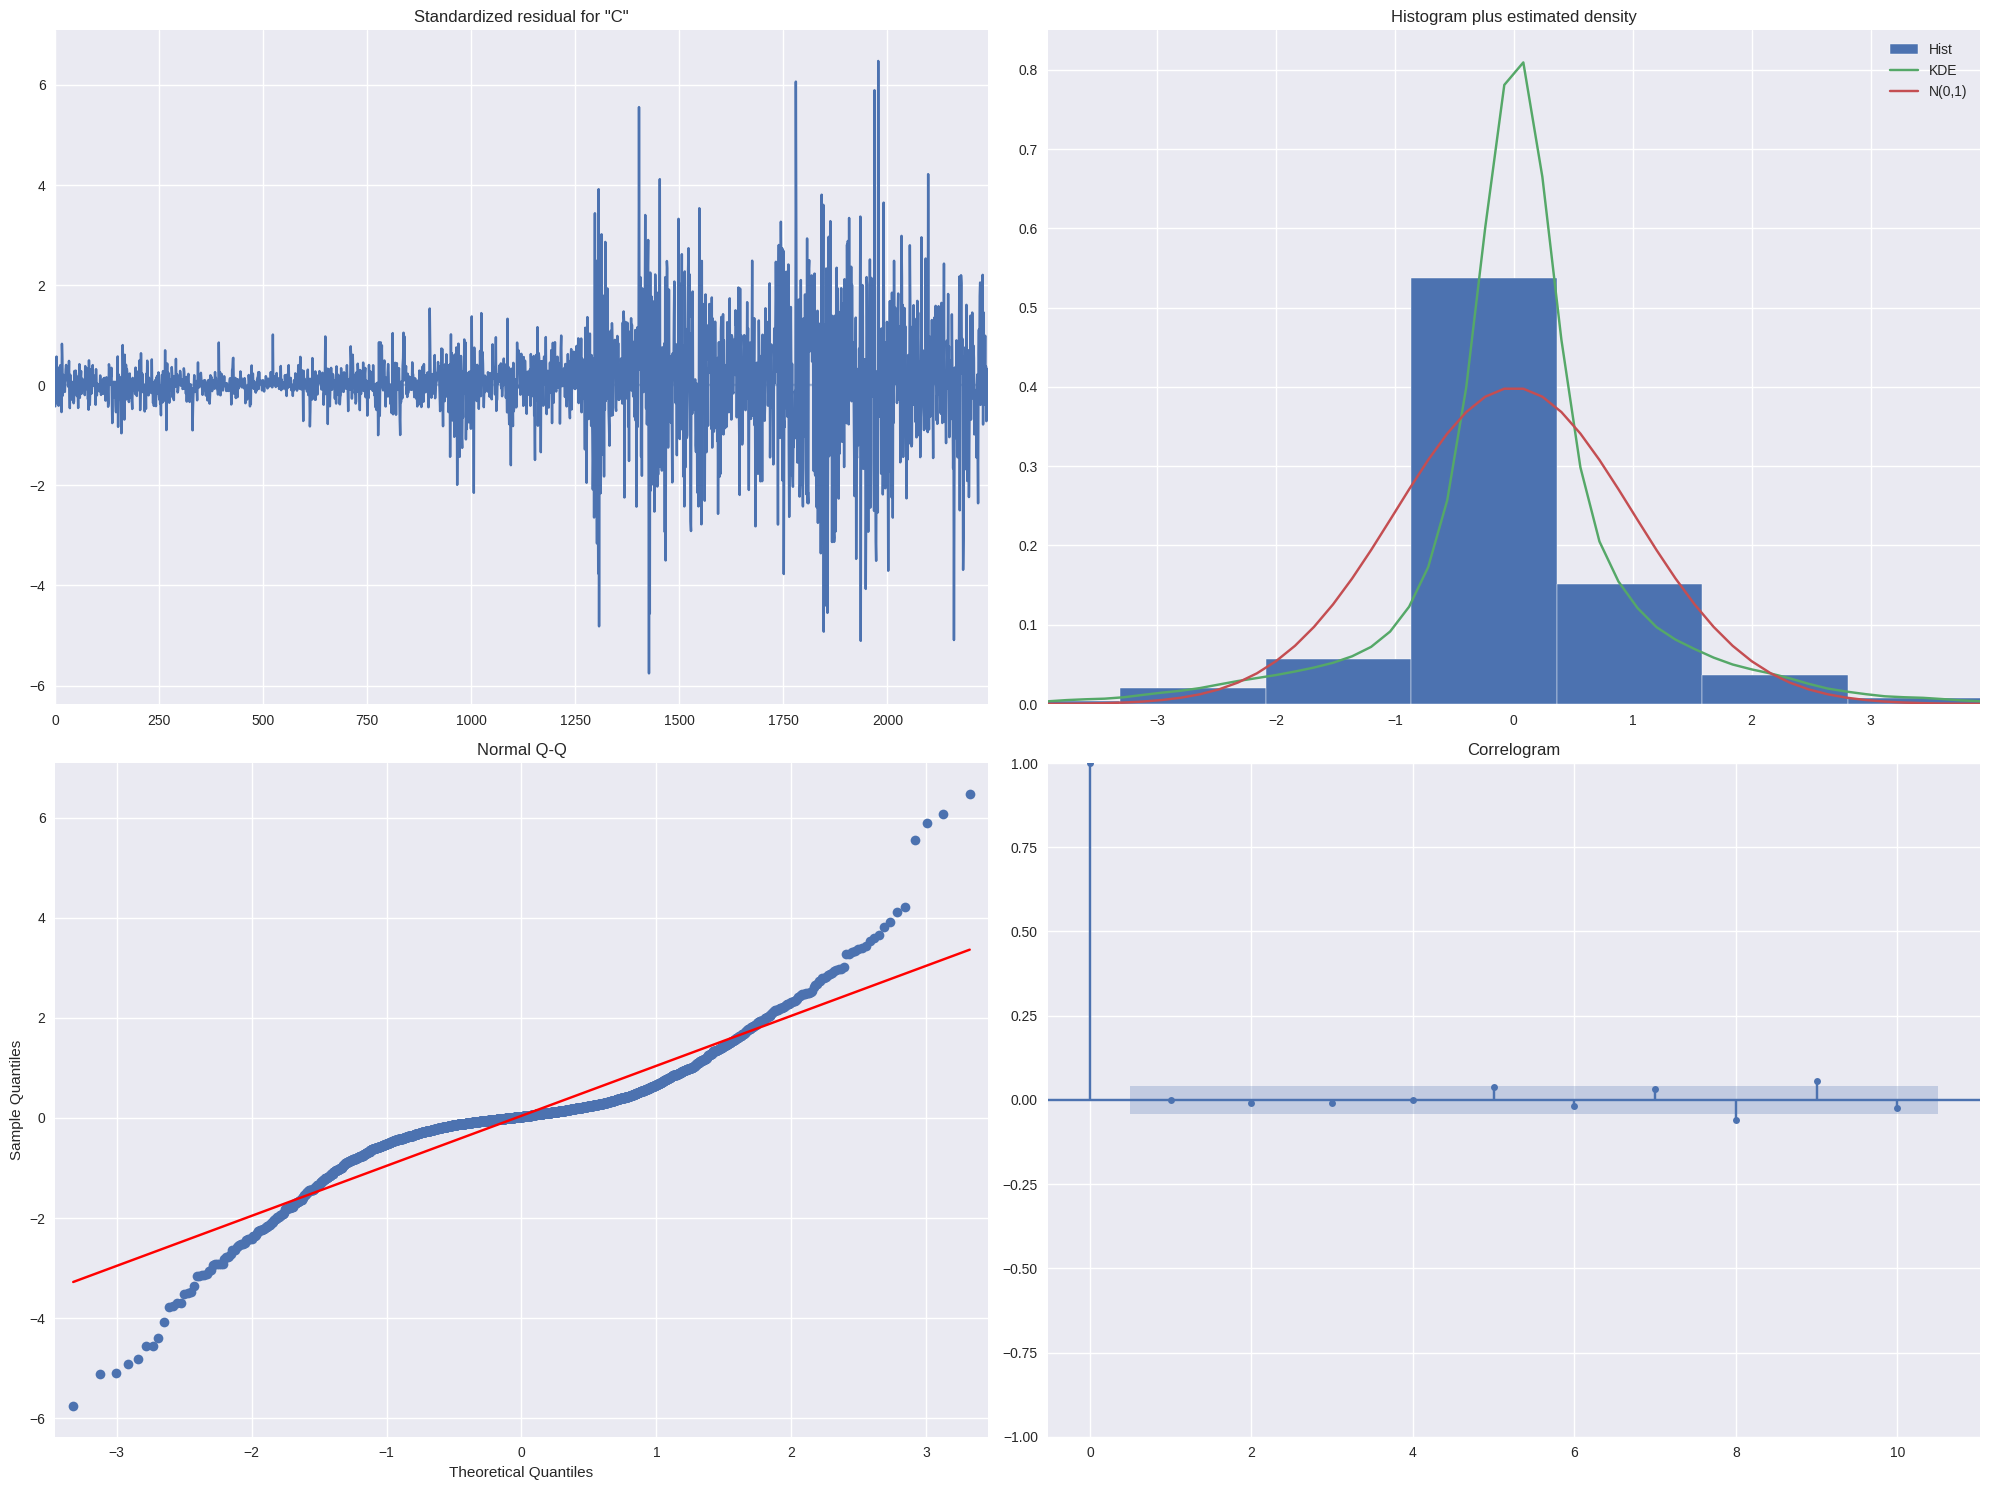

In [19]:
model_fit.plot_diagnostics()
plt.tight_layout()

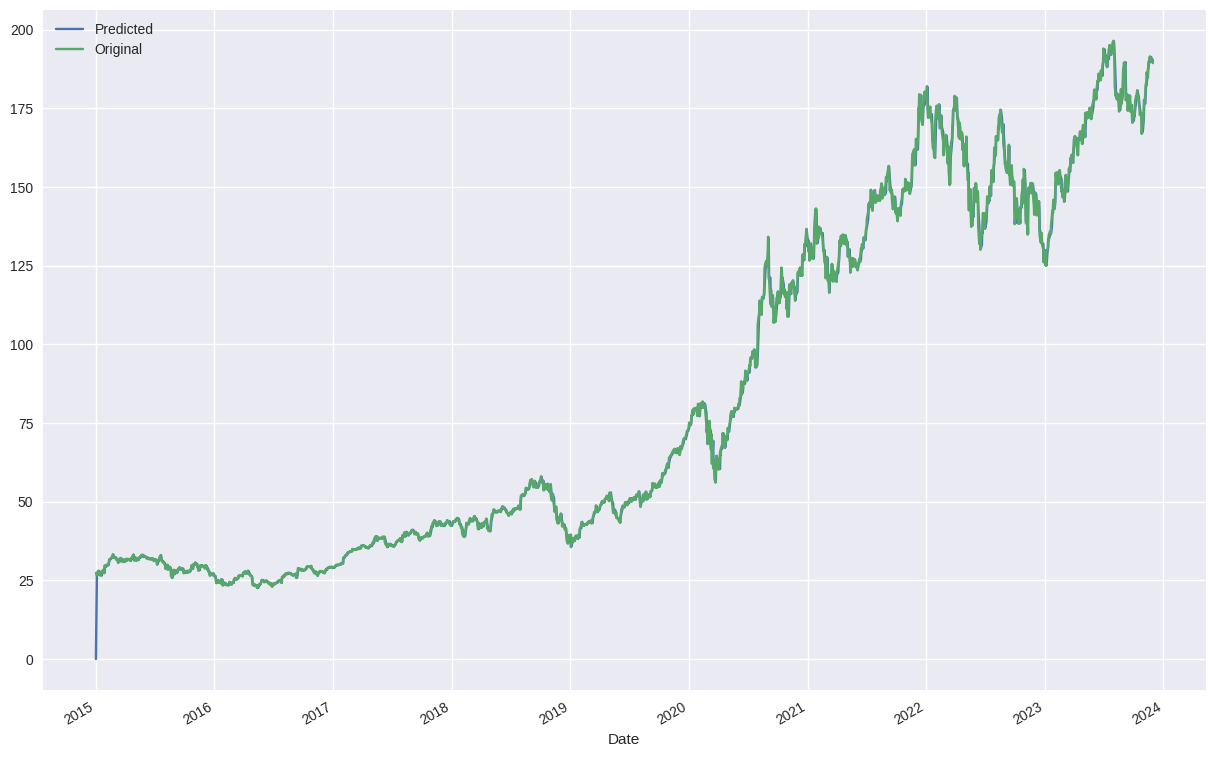

In [20]:
plt.figure(figsize=(15,10))
model_fit.predict(dynamic=False).plot(label='Predicted')
df.plot(label='Original')
plt.legend()

So far we have modelled using all data, which does not help us conclude if model is good. So now we do train test split.

In [21]:
train_size = int(len(df)*.85)

train, test = df[:train_size], df[train_size:]

In [22]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1906
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3638.863
Date:                Wed, 29 Nov 2023   AIC                           7283.727
Time:                        23:31:37   BIC                           7300.384
Sample:                             0   HQIC                          7289.858
                               - 1906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2585      0.181      1.427      0.154      -0.097       0.614
ma.L1         -0.3170      0.179     -1.772      0.076      -0.668       0.034
sigma2         2.6709      0.040     66.620      0.0

In [23]:
fc = pd.Series(model_fit.forecast(len(test)))
fc.index = test.index
fc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2022-07-29    157.231183
2022-08-01    157.200464
2022-08-02    157.192522
2022-08-03    157.190469
2022-08-04    157.189938
                 ...    
2023-11-22    157.189753
2023-11-24    157.189753
2023-11-27    157.189753
2023-11-28    157.189753
2023-11-29    157.189753
Name: predicted_mean, Length: 337, dtype: float64

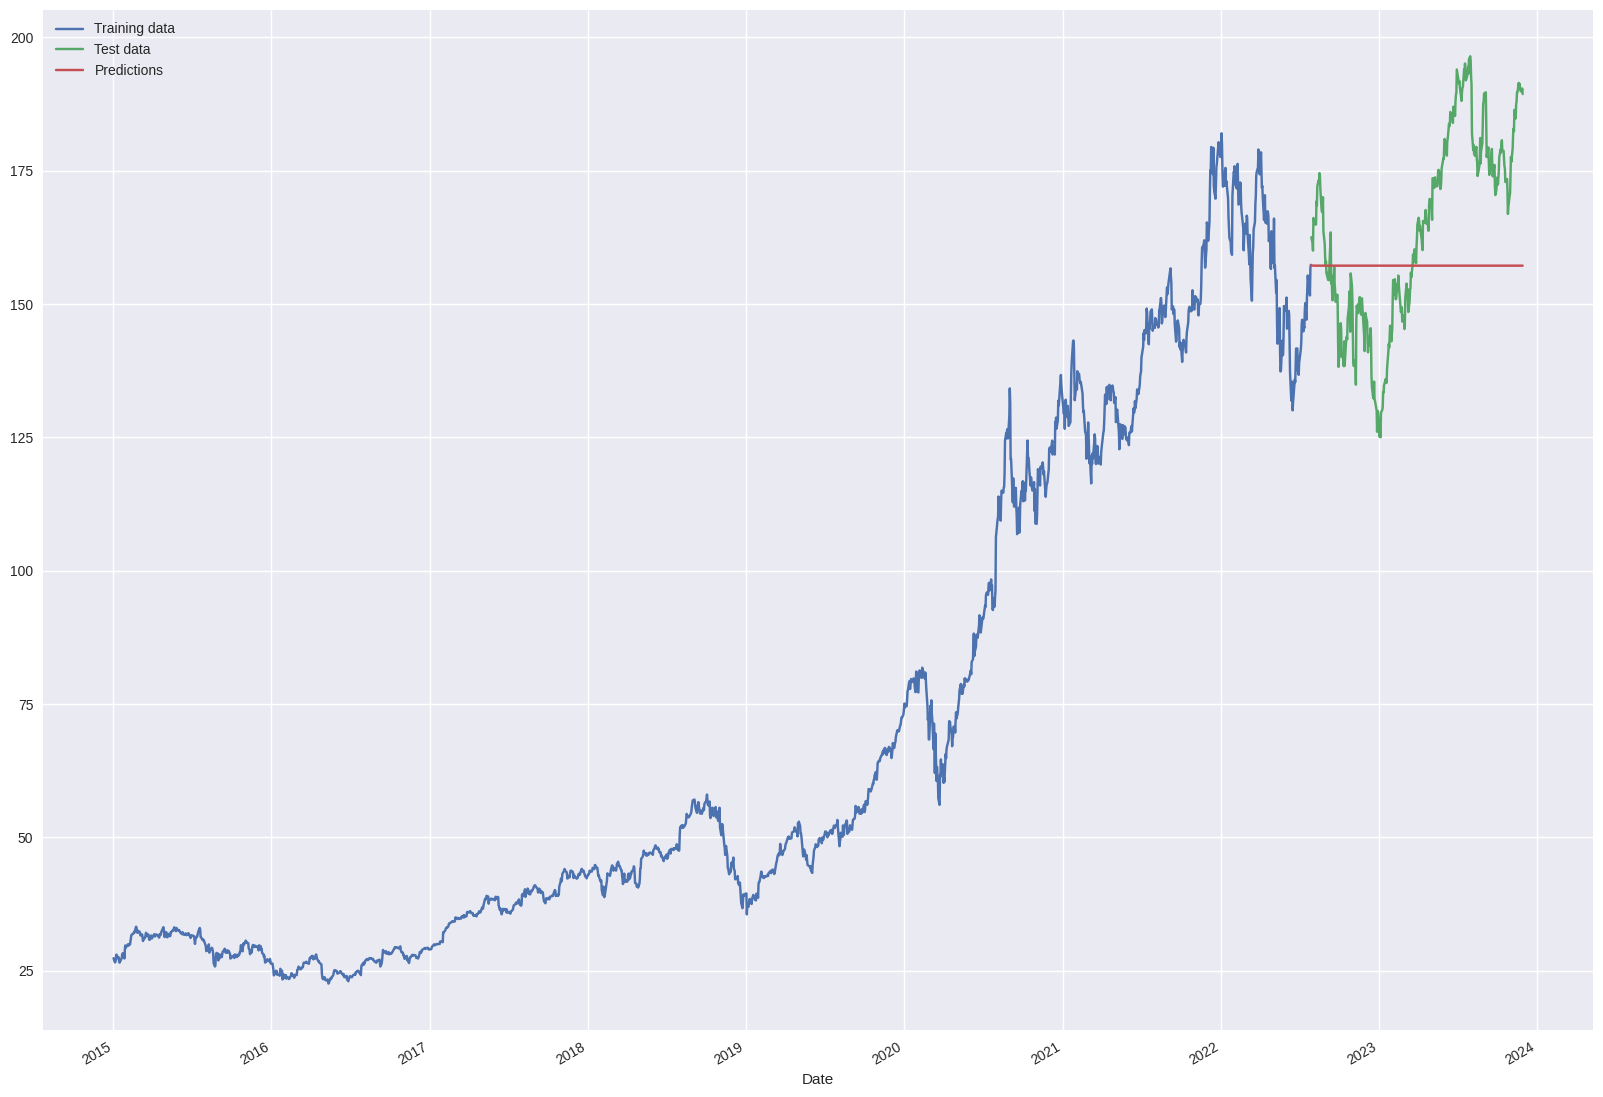

In [24]:
train.plot(label='Training data')
test.plot(label='Test data')
fc.plot(label='Predictions')
plt.legend()


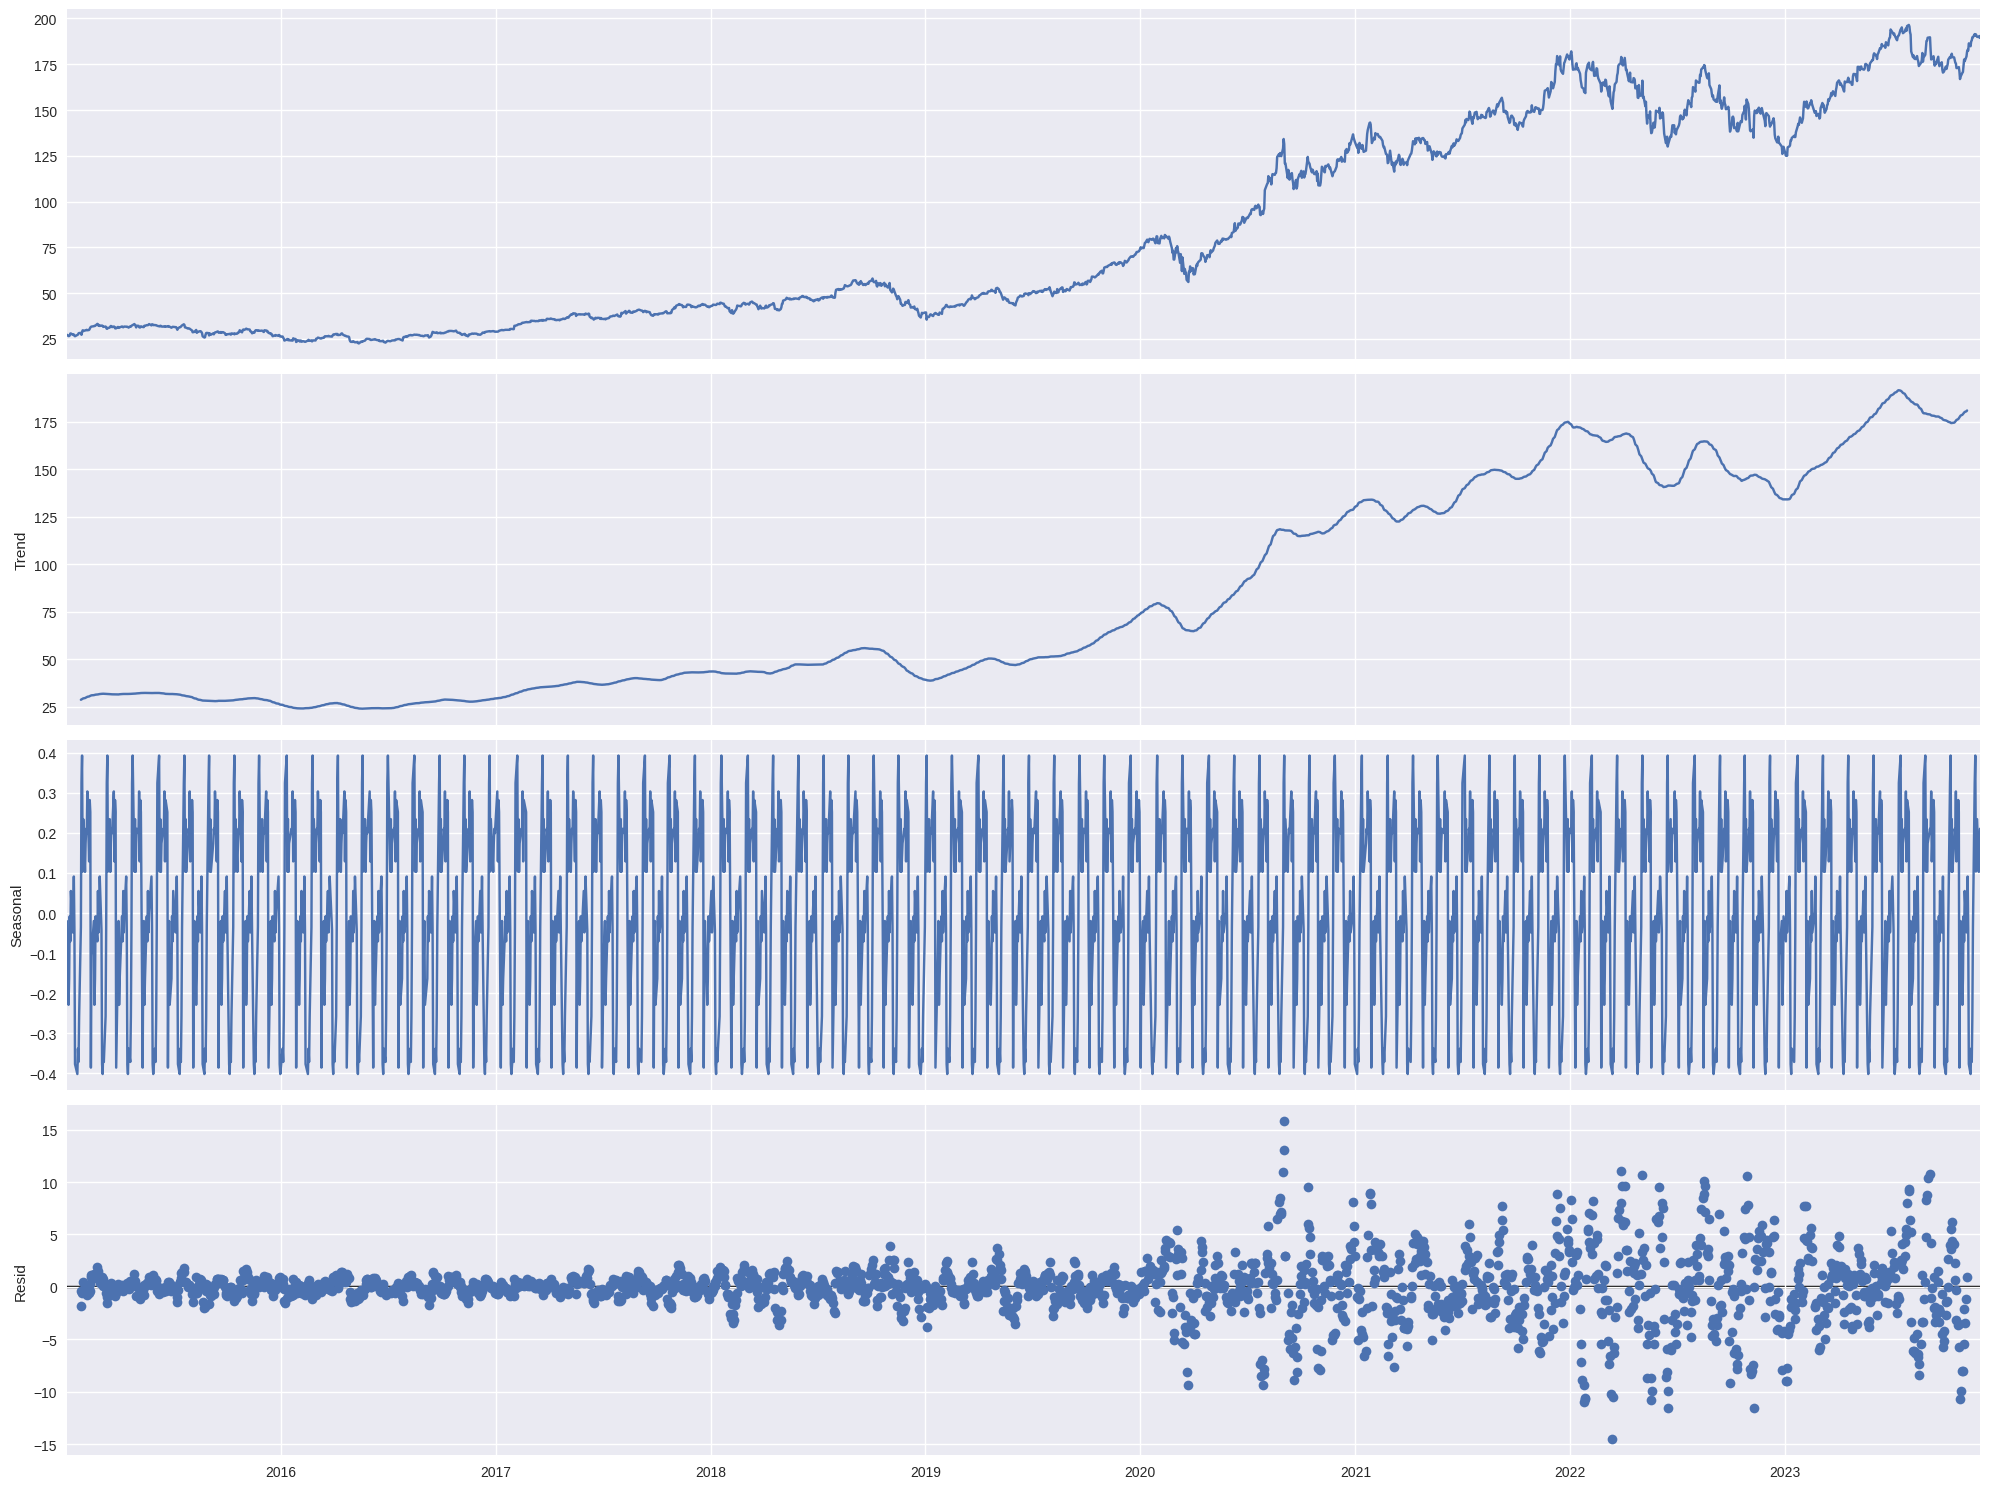

In [25]:
res = seasonal_decompose(pd.DataFrame(df), period=30, model='add')
res.plot();

# Auto ARIMA.


In [26]:
model = auto_arima(pd.DataFrame(df), max_p=6, max_q=3, m=5, seasonal=True, max_P=4, max_Q=4, max_D=2, max_order=None,
                   d=None, trace=True, trend='ct',
                   out_of_sample_size = int(len(df)*.2),
                   error_action='ignore',   # we don't want to know if an order does not work
                   suppress_warnings=True,  # we don't want convergence warnings
                   stepwise=True) # set to stepwise
model.summary()


Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=9393.104, Time=6.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=9064.423, Time=2.12 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=9063.030, Time=6.37 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=9062.628, Time=3.97 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(0,0,0)[5]             : AIC=9064.423, Time=1.26 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=9063.237, Time=5.79 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=9068.093, Time=4.63 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,2)[5] intercept   : AIC=9063.700, Time=7.71 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=9062.713, Time=4.36 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(1,0,2)[5] intercept   : AIC=9064.510, Time=11.29 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=9063.231, Time=6.73 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=9065.680, Time=5.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,1)[5] intercept   : AIC=9062.619, Time=9.96 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,0)[5] intercept   : AIC=9064.694, Time=3.17 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(1,0,1)[5] intercept   : AIC=9069.006, Time=9.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,2)[5] intercept   : AIC=9064.357, Time=14.46 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(1,0,0)[5] intercept   : AIC=9063.762, Time=7.80 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(1,0,2)[5] intercept   : AIC=9064.569, Time=15.68 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=9064.912, Time=10.98 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,3)(0,0,1)[5] intercept   : AIC=9065.093, Time=5.72 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,3)(0,0,1)[5] intercept   : AIC=9066.291, Time=17.28 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,1)[5]             : AIC=9062.619, Time=8.99 sec

Best model:  ARIMA(0,1,2)(0,0,1)[5]          
Total fit time: 168.511 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2243
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 5)   Log Likelihood               -4525.310
Date:                             Wed, 29 Nov 2023   AIC                           9062.619
Time:                                     23:34:32   BIC                           9096.910
Sample:                                          0   HQIC                          9075.137
                                            - 2243                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0298      0.183     -0.163      0.870      -0.388       0.329
drift       8.186e-05      0.000      0.777      0.437      -0.000       0.000
ma.L1         -0.0383      0.013     -3.003      0.003      -0.063      -0.013
ma.L2         -0.0250      0.013     -1.901      0.057      -0.051       0.001
ma.S.L5        0.0380      0.012      3.089      0.002       0.014       0.062
sigma2         3.3121      0.049     67.065      0.000       3.215       3.409
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3733.41
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              38.38   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
model = ARIMA(train, order=(0,2,1), seasonal_order=(0,0,0,5))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1906
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -3643.049
Date:                Wed, 29 Nov 2023   AIC                           7290.098
Time:                        23:34:33   BIC                           7301.201
Sample:                             0   HQIC                          7294.185
                               - 1906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9991      0.001   -744.249      0.000      -1.002      -0.996
sigma2         2.6792      0.040     66.810      0.000       2.601       2.758
Ljung-Box (L1) (Q):                   6.80   Jarque-

In [28]:
fc = pd.Series(model_fit.forecast(len(test)))
fc.index = test.index
fc

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2022-07-29    157.429737
2022-08-01    157.509469
2022-08-02    157.589200
2022-08-03    157.668931
2022-08-04    157.748662
                 ...    
2023-11-22    183.900504
2023-11-24    183.980235
2023-11-27    184.059967
2023-11-28    184.139698
2023-11-29    184.219429
Name: predicted_mean, Length: 337, dtype: float64

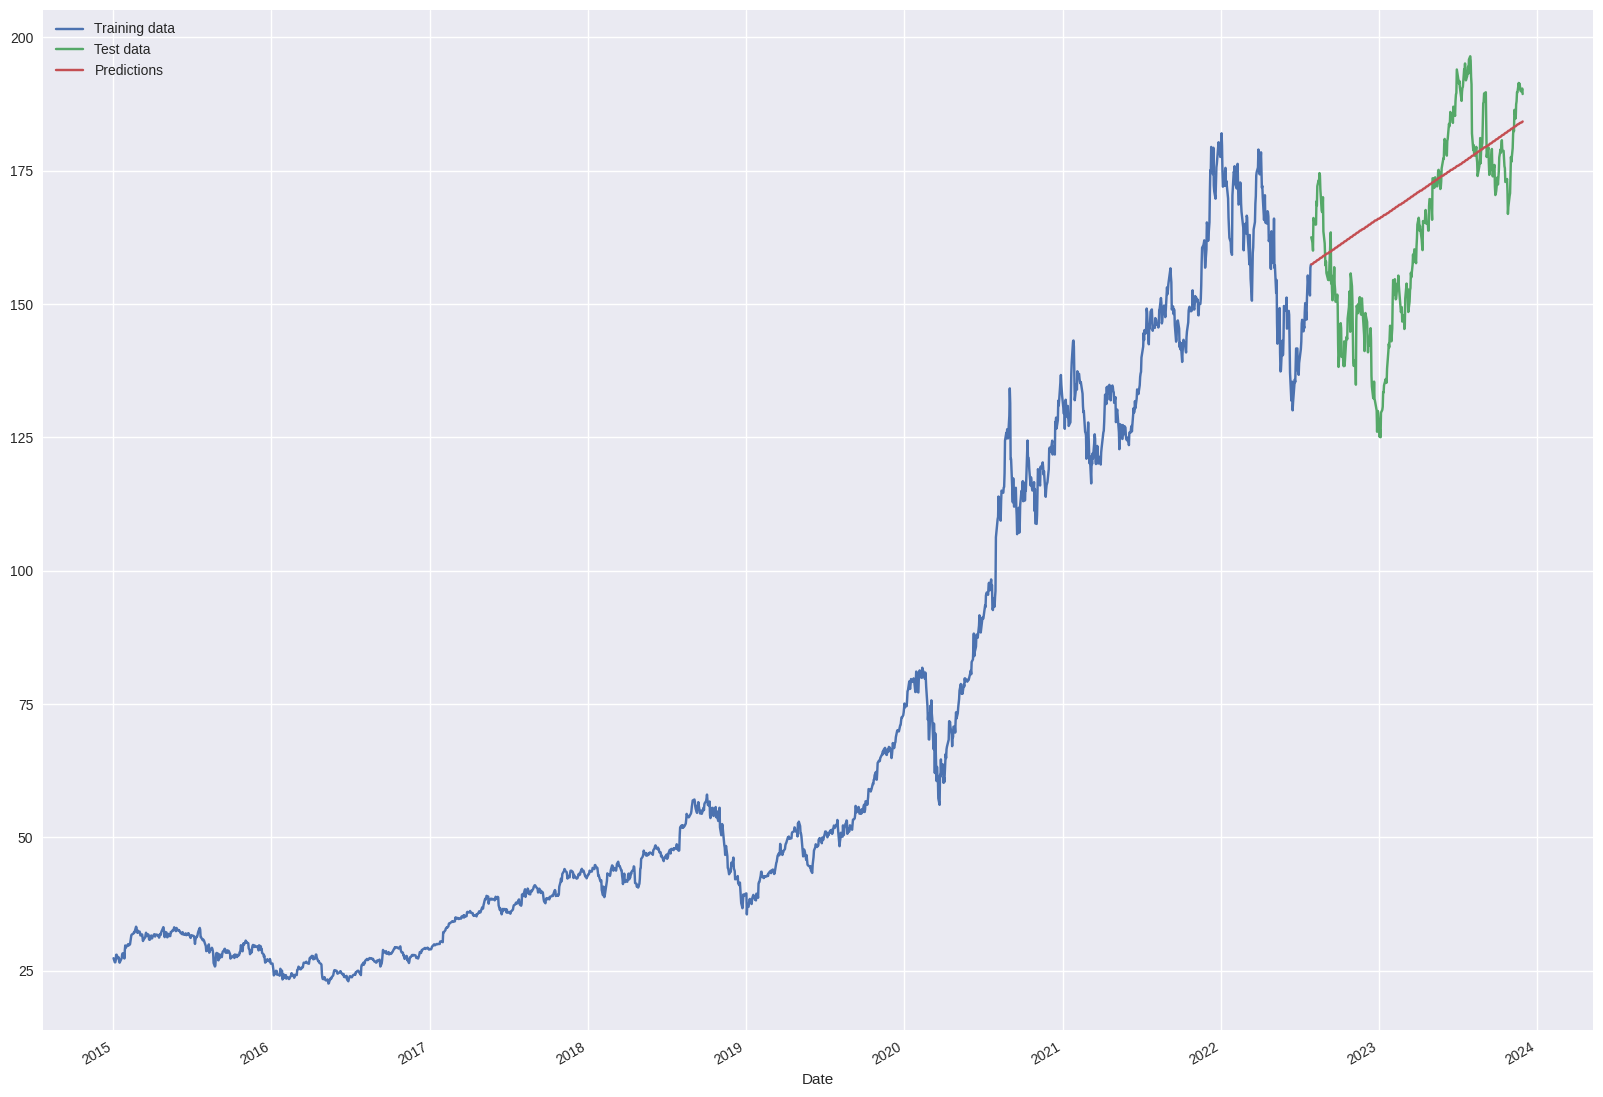

In [29]:
train.plot(label='Training data')
test.plot(label='Test data')
fc.plot(label='Predictions')
plt.legend()

In [33]:
for date, val in fc.iteritems():
    print(f"Date: {date}, Predicted value: {val:.2f}")


Date: 2022-07-29 00:00:00, Predicted value: 157.43
Date: 2022-08-01 00:00:00, Predicted value: 157.51
Date: 2022-08-02 00:00:00, Predicted value: 157.59
Date: 2022-08-03 00:00:00, Predicted value: 157.67
Date: 2022-08-04 00:00:00, Predicted value: 157.75
Date: 2022-08-05 00:00:00, Predicted value: 157.83
Date: 2022-08-08 00:00:00, Predicted value: 157.91
Date: 2022-08-09 00:00:00, Predicted value: 157.99
Date: 2022-08-10 00:00:00, Predicted value: 158.07
Date: 2022-08-11 00:00:00, Predicted value: 158.15
Date: 2022-08-12 00:00:00, Predicted value: 158.23
Date: 2022-08-15 00:00:00, Predicted value: 158.31
Date: 2022-08-16 00:00:00, Predicted value: 158.39
Date: 2022-08-17 00:00:00, Predicted value: 158.47
Date: 2022-08-18 00:00:00, Predicted value: 158.55
Date: 2022-08-19 00:00:00, Predicted value: 158.63
Date: 2022-08-22 00:00:00, Predicted value: 158.71
Date: 2022-08-23 00:00:00, Predicted value: 158.79
Date: 2022-08-24 00:00:00, Predicted value: 158.86
Date: 2022-08-25 00:00:00, Pred

<ipython-input-33-3f1b9b3b5ee7>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, val in fc.iteritems():
